In [1]:
# Import packages
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

The first step is to get the data and load it to memory. We will get our stock data from the Yahoo Finance website. Yahoo Finance is a rich resource of financial market data and tools to find compelling investments. To get the data from Yahoo Finance, we will be using yfinance library which offers a threaded and Pythonic way to download market data from Yahoo. 

# Data Gathering

In [2]:
# Set date timestamps for historical data download
start_date = datetime.datetime(2018, 1, 1).date()
end_date = datetime.datetime.now().date()
start_date, end_date

(datetime.date(2018, 1, 1), datetime.date(2023, 10, 5))

In [3]:
end_date - start_date

datetime.timedelta(days=2103)

In [4]:
ticker = "AKBNK.IS"


In [5]:
akbank = yf.Ticker(ticker)

akbank

yfinance.Ticker object <AKBNK.IS>

In [6]:
historical_data = akbank.history(start=start_date, end=end_date, interval="1d")

historical_data.shape

(1461, 7)

The above data shows stock prices on per day basis.

+ High: Max stock price on that particular day
+ Low: Lowest price went on that particular day
+ Open: Stock price opening on that particular day
+ Close: Final closing price of the stock on that particular day
+ Volume: Amount of stock traded on that day
+ Dividends: Dividens given (if any)
+ Stock Splits: Stock split happend on that particular day (if any)

In [8]:
df=pd.read_csv("C:\\Users\\rania\\Downloads\\warren-main\\warren-main\\src\\notebooks\\data\\AKBNK.IS_historical_data.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

C:\Users\rania\AppData\Local\Temp\ipykernel_23968\1574427061.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv("C:\\Users\\rania\\Downloads\\warren-main\\warren-main\\src\\notebooks\\data\\AKBNK.IS_historical_data.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0
2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109
2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228
2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157
2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896


# Descriptive Statistics about the Data
.describe() generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values.

Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more detail.

In [9]:
df.descripe()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0
2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109
2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228
2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157
2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896


The trading volume statistics indicate that the average daily trading volume is approximately 99,782,730 shares, with a wide range from 0 (which might need to be addressed as it's unusual) to a maximum of approximately 988,525,300 shares.

# 1. What was the change in price of the stock overtime?
In this section we'll go over how to handle requesting stock information with pandas, and how to analyze basic attributes of a stock.

# How does the closing price of AKBANK change over time, as shown in the plot?

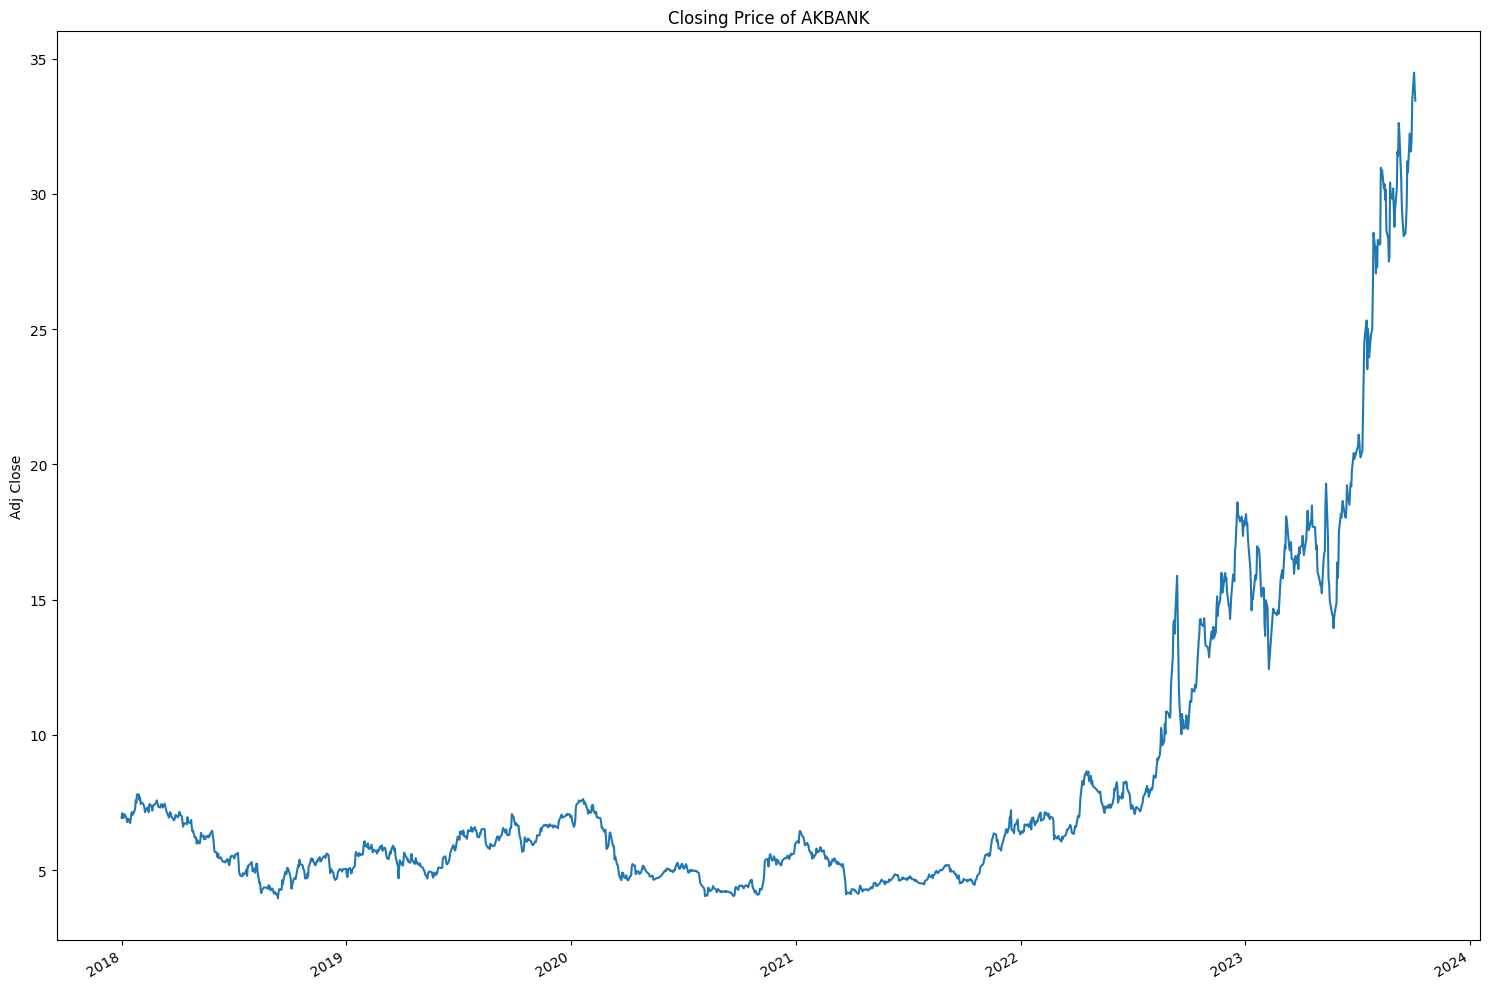

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of AKBANK")   
plt.tight_layout()


An increasing trend in a stock's closing price is often seen as a positive sign by investors, as it suggests that the company's performance or market sentiment is favorable. 

# Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

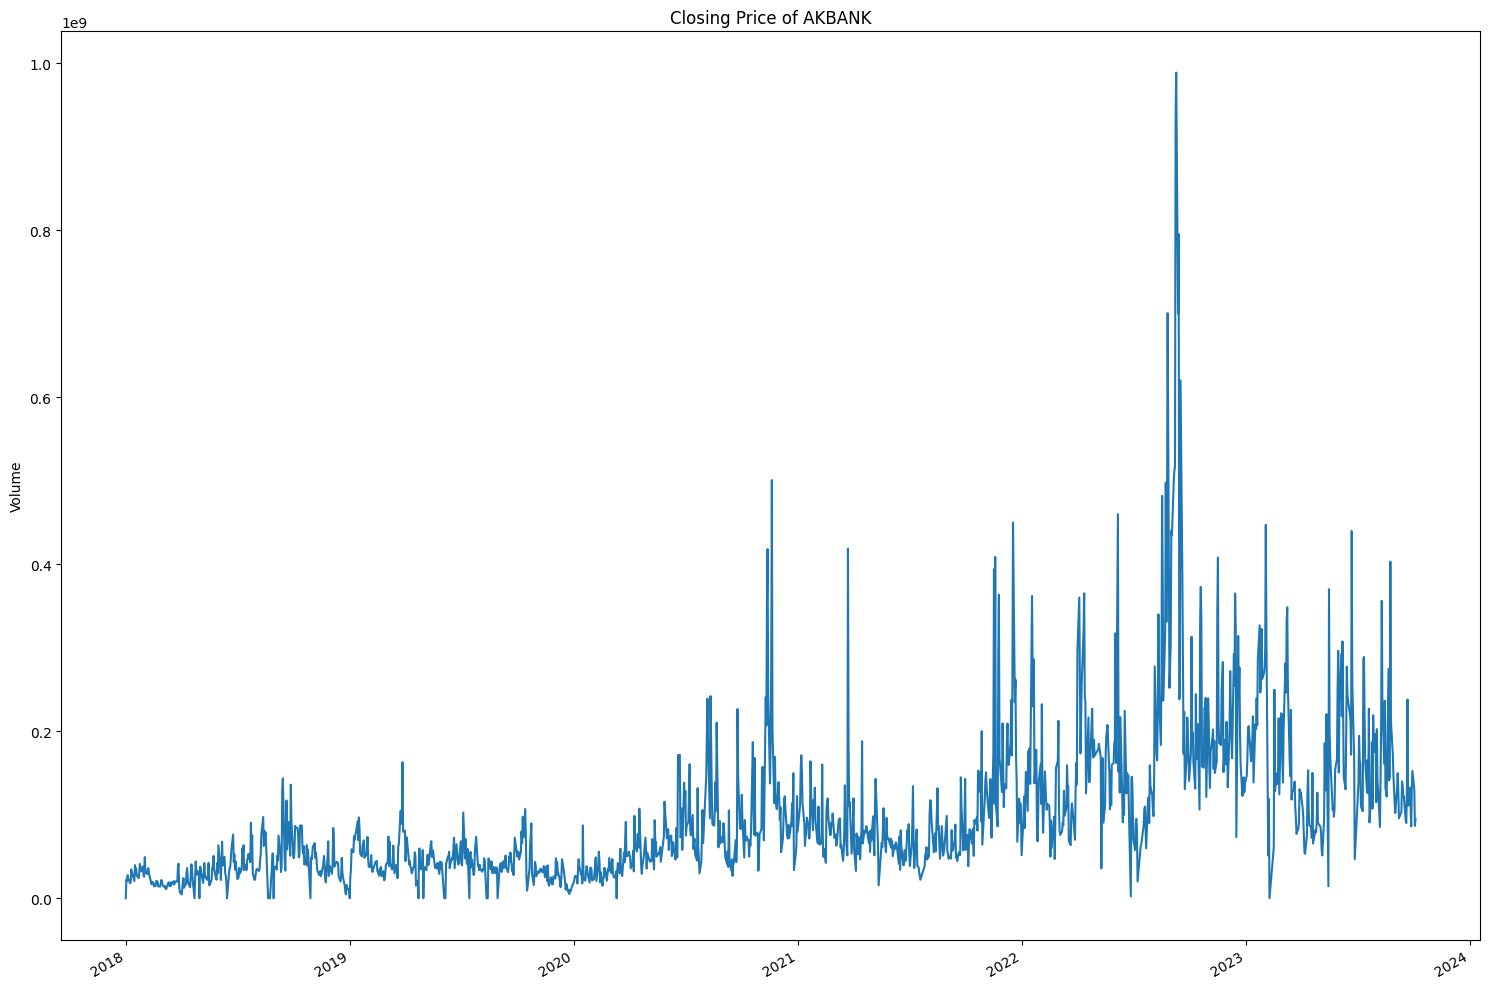

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Closing Price of AKBANK")   
plt.tight_layout()


in the middle of 2022 we can see   high volume can indicate increased market activity and potentially significant price movements, but the interpretation of volume should consider other factors such as price patterns, news, and overall market conditions. and we can see from the turkey stats that cuz of inflation happen

# What was the moving average of the AKBANK stock?
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

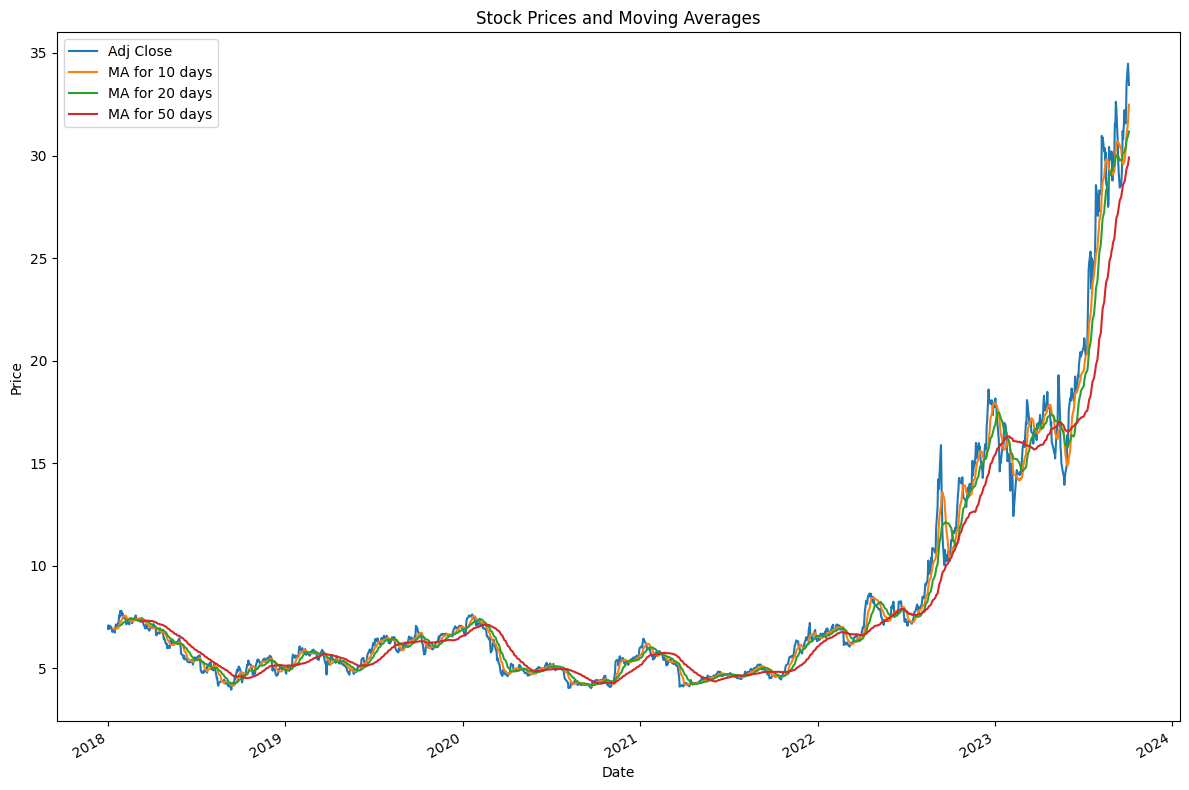

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'company_df' with the relevant data
# Calculate moving averages for different periods (e.g., 10, 20, 50 days)
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

# Create a plot with subplots for stock prices and moving averages
fig, ax = plt.subplots(figsize=(12, 8))

df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)

# Set titles and labels
ax.set_title('Stock Prices and Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='best')

plt.tight_layout()
plt.show()


You can observe the trends in the stock's price movements over time. The adjusted close price is plotted along with the three moving averages. Moving averages smooth out short-term fluctuations and help identify trends. For example:

The 10-day MA responds more quickly to recent price changes.
The 20-day MA responds average to recent price changes.
The 50-day MA provides a smoother curve and represents a longer-term trend.

 we can see the short-term 10-day MA crosses above the longer-term 50-day MA, it might be considered a "golden cross," indicating a potential bullish trend.

A stock staying above its MAs can indicate strength in the current trend. It suggests that there is buying interest, and investors 
 
stock price remains above its MAs, it suggests that the stock is in an uptrend. This means that, on average, the stock's price is increasing over the selected timeframes represented by the MAs 10 days, 20 days, and 50 days

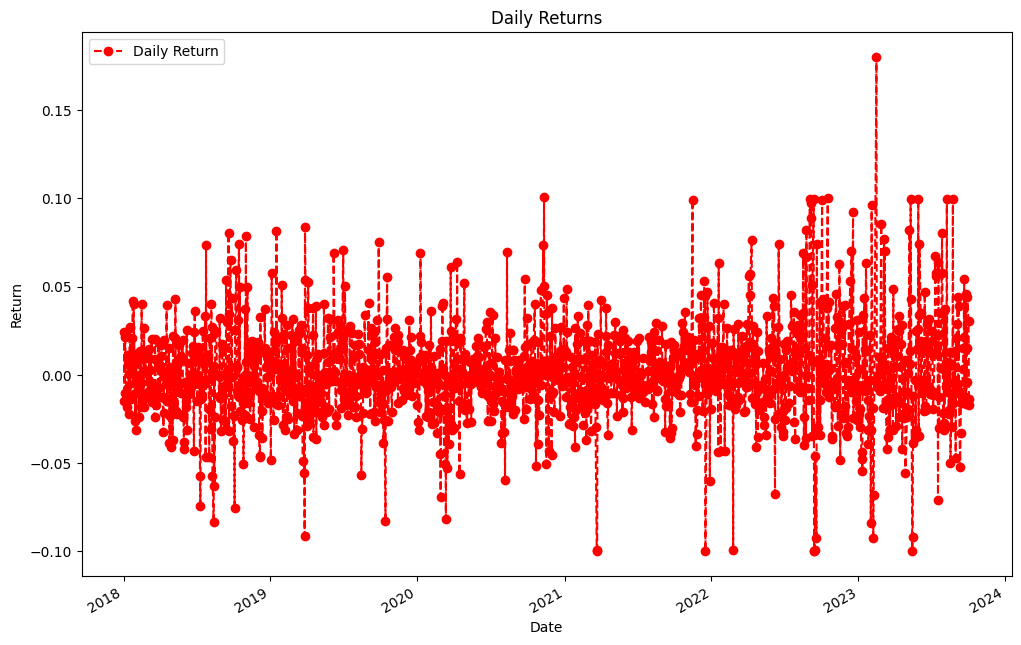

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with the relevant data
# Calculate daily returns
df['Daily Return'] = df['Adj Close'].pct_change()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plot daily returns
df['Daily Return'].plot(legend=True, linestyle='--', marker='o', color='r')

# Customize labels and title
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Returns')

plt.show()


Daily returns are a common metric in finance used to measure the day-to-day price fluctuations of an asset.
we can gain insights into the asset's day-to-day price movements, volatility, and potential trends. It's a common practice in financial analysis to study daily returns to assess risk and evaluate investment performance.

it seems that from 2020 the rate of risks become high and the amount of investment become more high as well
but it become decreseing slightly from the last months of 2023

Text(0, 0.5, 'Counts')

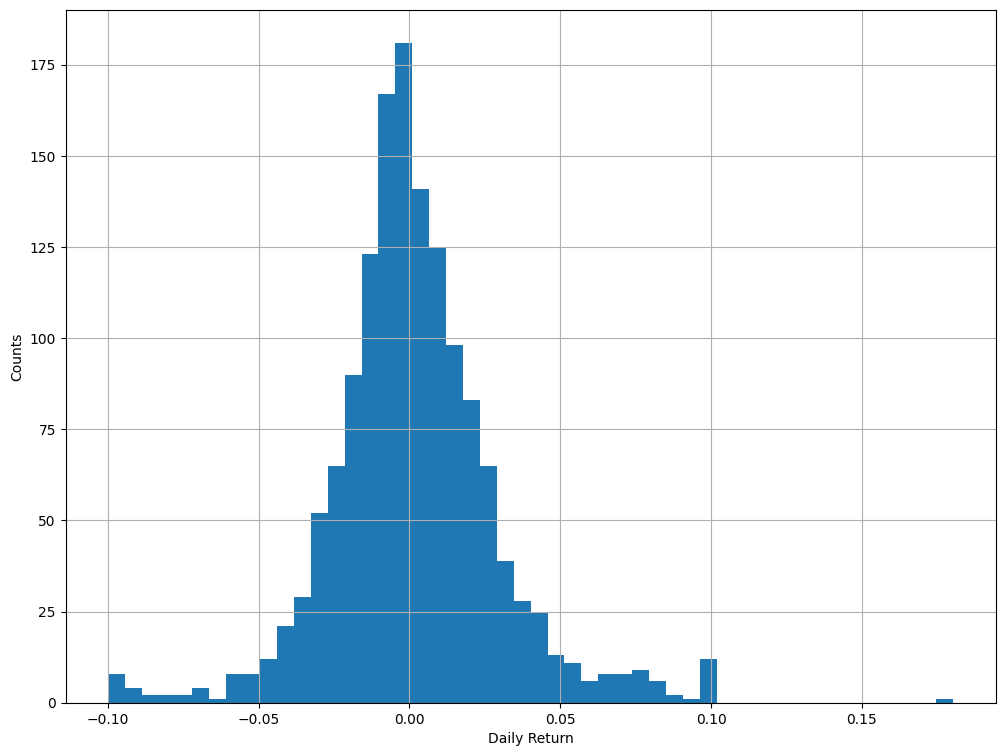

In [20]:
plt.figure(figsize=(12, 9))
df['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')

we can see from this plot is slightly normal and the 95% confidence interval that the losses and the gains slightly equal with some outlire of gains thats means that the bank should come out of the bart of comfort zone and make high risks to gain more 

In [31]:
import yfinance as yf
import datetime

# Set the start and end date for historical data
# Set date timestamps for historical data download
start_date = datetime.datetime(2018, 1, 1).date()
end_date = datetime.datetime.now().date()
akbank_data = yf.download("AKBNK.IS", start=start_date, end=end_date)
closing_prices = akbank_data['Adj Close']
daily_returns = closing_prices.pct_change()

print(daily_returns.head())


[*********************100%%**********************]  1 of 1 completed
Date
2018-01-01         NaN
2018-01-02    0.024365
2018-01-03   -0.014866
2018-01-04   -0.010061
2018-01-05    0.021342
Name: Adj Close, dtype: float64


# How much value do we put at risk by investing in a particular stock?
There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

C:\Users\rania\AppData\Local\Temp\ipykernel_23968\4222949494.py:9: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.

c:\Users\rania\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning:

invalid value encountered in reduce

c:\Users\rania\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning:

invalid value encountered in subtract



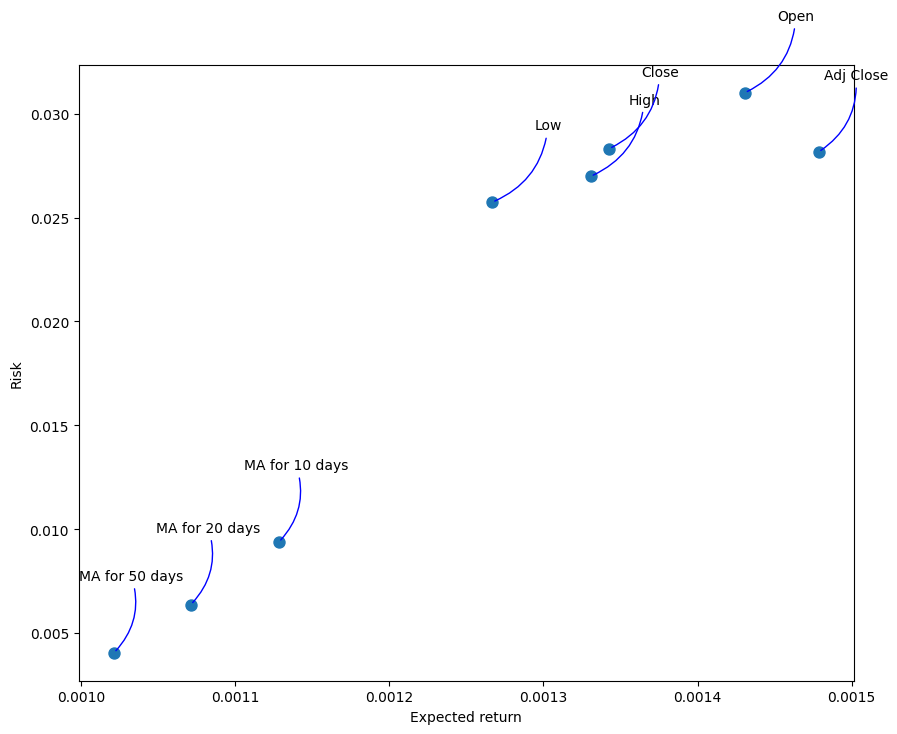

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'my_data' with the relevant data
# Make sure 'my_data' contains columns for daily closing prices ('Adj Close') for multiple stocks

# Calculate daily returns for multiple stocks
returns_df = df.pct_change()
returns_df = returns_df.dropna()

# Calculate mean and standard deviation of returns
mean_returns = returns_df.mean()
std_deviation = returns_df.std()

# Set the size for scatter points
area = np.pi * 20

# Create a scatter plot for expected return vs. risk
plt.figure(figsize=(10, 8))
plt.scatter(mean_returns, std_deviation, s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

# Annotate the points with stock labels
for label, x, y in zip(returns_df.columns, mean_returns, std_deviation):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.show()


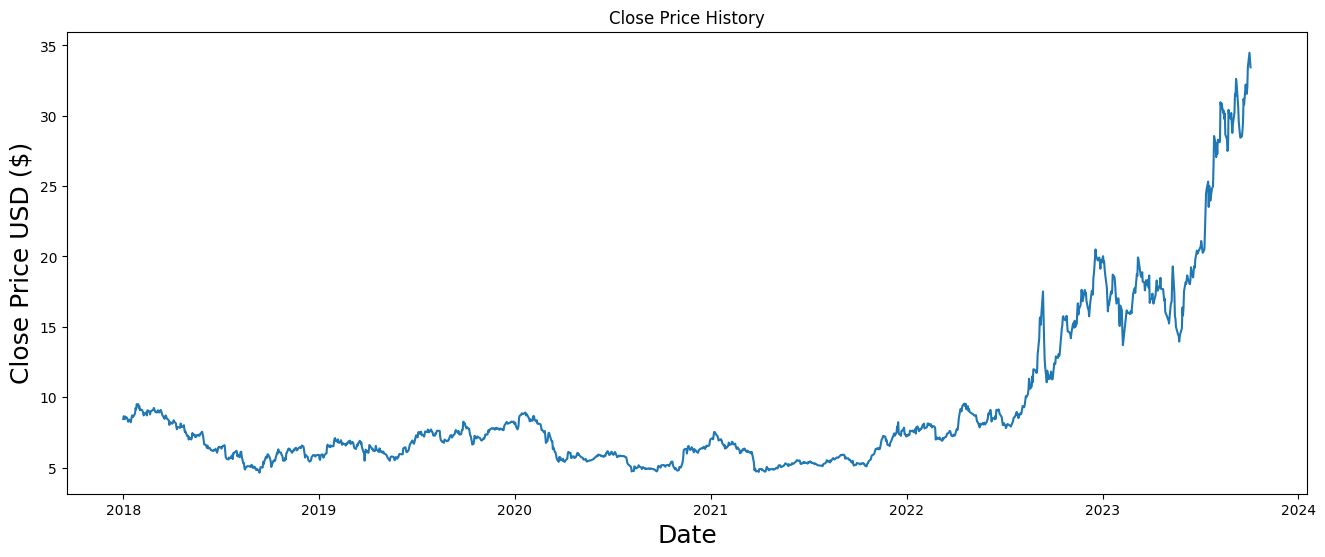

In [39]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

we can see the longterm trend is increasing cuz of inflation happen in the last years across the world may affect the bank close stocks

In [43]:
df.reset_index()

,Date,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
0,2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0,NaN,NaN,NaN,NaN
1,2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109,NaN,NaN,NaN,0.024366
2,2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228,NaN,NaN,NaN,-0.014866
3,2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157,NaN,NaN,NaN,-0.010061
4,2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896,NaN,NaN,NaN,0.021342
...,...,...,...,...,...,...,...,...,...,...,...
1456,2023-09-28,31.580000,32.500000,31.440001,32.040001,32.040001,134636143,30.506,30.536,29.1656,0.015209
1457,2023-09-29,32.540001,34.220001,32.480000,33.459999,33.459999,152427587,31.008,30.740,29.3408,0.044320
1458,2023-10-02,33.480000,35.200001,33.160000,34.480000,34.480000,130396219,31.602,30.953,29.5512,0.030484
1459,2023-10-03,34.740002,35.099998,33.500000,33.900002,33.900002,86596571,32.094,31.070,29.7332,-0.016821


# Modeling 

In [73]:
validation_period = 30  # 30 days
# Create a new dataframe with only the 'Close' column
data = df[['Close']]
# Convert the dataframe to a numpy array
dataset = data.values
# Remove the last 30 rows for validation
train_dataset = dataset[:-validation_period]
validation_dataset=historical_data.iloc[-validation_period:]
training_data_len=len(train_dataset)

In [72]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data


array([[0.12782774],
       [0.13472182],
       [0.13041303],
       ...,
       [1.        ],
       [0.98056945],
       [0.96515886]])

In [74]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape


[array([0.12782774, 0.13472182, 0.13041303, 0.12754046, 0.1335728 ,
       0.13041303, 0.12667873, 0.12150818, 0.1232317 , 0.12639147,
       0.12007191, 0.12754046, 0.13500907, 0.13644531, 0.13242378,
       0.13845613, 0.14190315, 0.15425506, 0.150808  , 0.16315991,
       0.16315991, 0.15482956, 0.15856384, 0.14879722, 0.150808  ,
       0.14937173, 0.14621196, 0.14362667, 0.13644531, 0.13931786,
       0.14333942, 0.14190315, 0.13644531, 0.14822271, 0.14851   ,
       0.14420118, 0.13874335, 0.14649919, 0.14678647, 0.14736098,
       0.15023349, 0.15425506, 0.150808  , 0.14736098, 0.14448844,
       0.14333942, 0.1476482 , 0.14851   , 0.14736098, 0.14333942,
       0.14937173, 0.1453502 , 0.14075413, 0.13701982, 0.13500907,
       0.12811497, 0.13386005, 0.13644531, 0.13443456, 0.12955127])]
[0.12610421709700304]

[array([0.12782774, 0.13472182, 0.13041303, 0.12754046, 0.1335728 ,
       0.13041303, 0.12667873, 0.12150818, 0.1232317 , 0.12639147,
       0.12007191, 0.12754046, 0.13

In [75]:
x_train.shape,y_train.shape


((1371, 60, 1), (1371,))

In [88]:
from keras.layers import LSTM, Dense, Dropout

# Build the LSTM model with additional layers
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))  # You can add more LSTM layers
model.add(Dense(64))  # Additional dense layers
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1371/1371 [==============================] - 37s 23ms/step - loss: 0.0041
Epoch 2/5
1371/1371 [==============================] - 30s 22ms/step - loss: 0.0016
Epoch 3/5
1371/1371 [==============================] - 29s 21ms/step - loss: 8.2190e-04
Epoch 4/5
1371/1371 [==============================] - 24s 18ms/step - loss: 0.0014
Epoch 5/5
1371/1371 [==============================] - 31s 23ms/step - loss: 5.9222e-04


In [89]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_tes
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate R-squared (R^2) score
r2 = r2_score(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE) as you did before
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# Print all the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2) score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)


1/1 [==============================] - 4s 4s/step
Mean Absolute Error (MAE): 1.5751598993937175
Mean Squared Error (MSE): 3.427279369591391
R-squared (R^2) score: -0.13158349248631662
Root Mean Squared Error (RMSE): 1.8512912708678206


In [90]:
valid = data[training_data_len:]
valid.shape

(30, 1)

C:\Users\rania\AppData\Local\Temp\ipykernel_23968\2388977846.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



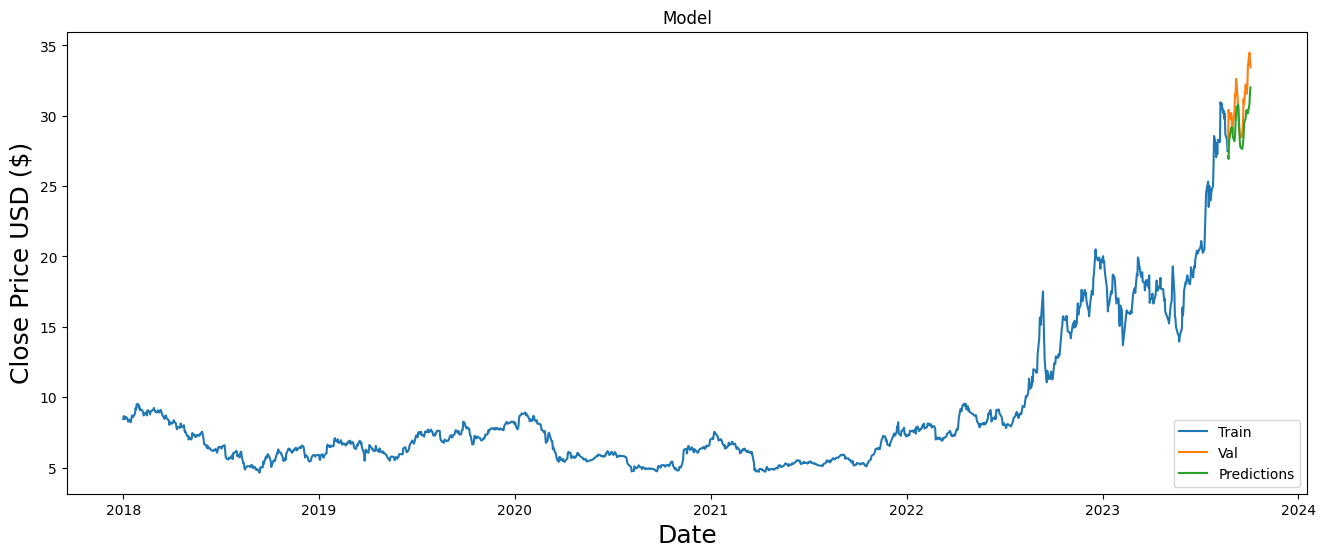

In [91]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [60]:
valid


,Close,Predictions
Date,,
2023-06-20,19.040001,19.655922
2023-06-21,19.309999,20.342421
2023-06-22,19.190001,20.638161
2023-06-23,19.790001,20.457523
2023-06-26,20.420000,21.195772
...,...,...
2023-09-28,32.040001,32.834610
2023-09-29,33.459999,33.433788
2023-10-02,34.480000,35.199432


## Facebook's Prophet: Single Timestep Forecasting

References: 
+ https://facebook.github.io/prophet/

In [102]:
historical_data=historical_data.reset_index()

historical_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0
1,2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109
2,2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228
3,2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157
4,2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896


In [105]:
# Create lag features
for i in range(1, 7):
    historical_data[f"Close_lag_{i}"] = historical_data.Close.shift(periods=i, axis=0)
    historical_data[f"Open_lag_{i}"] = historical_data.Open.shift(periods=i, axis=0)
    historical_data[f"High_lag_{i}"] = historical_data.High.shift(periods=i, axis=0)
    historical_data[f"Low_lag_{i}"] = historical_data.Low.shift(periods=i, axis=0)

historical_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_lag_1,Open_lag_1,High_lag_1,...,High_lag_4,Low_lag_4,Close_lag_5,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_6,Open_lag_6,High_lag_6,Low_lag_6
0,2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109,8.445837,8.445837,8.445837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228,8.651624,8.454411,8.703070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157,8.523007,8.677347,8.754517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896,8.437262,8.523007,8.694496,...,8.445837,8.445837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
historical_data.fillna(0, inplace=True)
historical_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_lag_1,Open_lag_1,High_lag_1,...,High_lag_4,Low_lag_4,Close_lag_5,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_6,Open_lag_6,High_lag_6,Low_lag_6
0,2018-01-01,8.445837,8.445837,8.445837,8.445837,6.937241,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,8.454411,8.703070,8.454411,8.651624,7.106271,22346109,8.445837,8.445837,8.445837,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03,8.677347,8.754517,8.497284,8.523007,7.000628,20362228,8.651624,8.454411,8.703070,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04,8.523007,8.694496,8.214327,8.437262,6.930197,27611157,8.523007,8.677347,8.754517,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05,8.488709,8.660198,8.454411,8.617326,7.078099,23811896,8.437262,8.523007,8.694496,...,8.445837,8.445837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
historical_data.drop(
    columns=["Volume", "Open", "High", "Low"], inplace=True)

In [109]:
import prophet as prophet
validation_period = 30 # 30 days

train, validation = historical_data.iloc[:-validation_period], historical_data.iloc[-validation_period:]

train.shape, validation.shape

((1431, 27), (30, 27))

In [110]:
train.head()

,Date,Close,Adj Close,Close_lag_1,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_2,Open_lag_2,High_lag_2,...,High_lag_4,Low_lag_4,Close_lag_5,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_6,Open_lag_6,High_lag_6,Low_lag_6
0,2018-01-01,8.445837,6.937241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,8.651624,7.106271,8.445837,8.445837,8.445837,8.445837,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03,8.523007,7.000628,8.651624,8.454411,8.703070,8.454411,8.445837,8.445837,8.445837,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04,8.437262,6.930197,8.523007,8.677347,8.754517,8.497284,8.651624,8.454411,8.703070,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05,8.617326,7.078099,8.437262,8.523007,8.694496,8.214327,8.523007,8.677347,8.754517,...,8.445837,8.445837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
lag_features = [col for col in historical_data.columns if "lag" in col]
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")
for name in lag_features:
    model.add_regressor(name)

model.fit(df=train.rename(columns={"Date": "ds", "Close":"y"}))

21:17:04 - cmdstanpy - INFO - Chain [1] start processing
21:17:05 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
forecast = model.predict(validation[[col for col in validation.columns if col != "Close"]].rename(columns={"Date": "ds"}))

forecast.shape

(30, 94)

In [113]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Close_lag_1,Close_lag_1_lower,Close_lag_1_upper,Close_lag_2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-23,9.846056,26.559897,27.493393,9.846056,9.846056,18.134624,18.134624,18.134624,1.069892,...,0.071176,0.071176,0.071176,0.014645,0.014645,0.014645,0.0,0.0,0.0,27.030438
1,2023-08-24,9.848932,26.650283,27.608942,9.848932,9.848932,18.288275,18.288275,18.288275,1.024373,...,0.054164,0.054164,0.054164,0.018625,0.018625,0.018625,0.0,0.0,0.0,27.131216
2,2023-08-25,9.851808,29.964419,30.945157,9.851808,9.851808,20.938770,20.938770,20.938770,1.033044,...,0.067944,0.067944,0.067944,0.022735,0.022735,0.022735,0.0,0.0,0.0,30.445378
3,2023-08-28,9.860436,29.435998,30.366647,9.860436,9.860436,20.477815,20.477815,20.477815,1.182606,...,0.126334,0.126334,0.126334,0.034315,0.034315,0.034315,0.0,0.0,0.0,29.890014
4,2023-08-29,9.863312,29.005495,29.992877,9.863312,9.863312,20.343368,20.343368,20.343368,1.156595,...,0.044706,0.044706,0.044706,0.037432,0.037432,0.037432,0.0,0.0,0.0,29.500354
5,2023-08-31,9.869064,29.579374,30.573097,9.869064,9.869064,20.727499,20.727499,20.727499,1.149008,...,0.054164,0.054164,0.054164,0.041772,0.041772,0.041772,0.0,0.0,0.0,30.074798
6,2023-09-01,9.871940,28.009180,28.964781,9.871940,9.871940,19.363839,19.363839,19.363839,1.170684,...,0.067944,0.067944,0.067944,0.042792,0.042792,0.042792,0.0,0.0,0.0,28.475032
7,2023-09-04,9.880569,28.714203,29.651019,9.880569,9.880569,19.940032,19.940032,19.940032,1.093736,...,0.126334,0.126334,0.126334,0.040506,0.040506,0.040506,0.0,0.0,0.0,29.192420
8,2023-09-05,9.883445,29.420481,30.341832,9.883445,9.883445,20.746704,20.746704,20.746704,1.126249,...,0.044706,0.044706,0.044706,0.037902,0.037902,0.037902,0.0,0.0,0.0,29.868393
9,2023-09-06,9.886321,30.403396,31.315281,9.886321,9.886321,22.033538,22.033538,22.033538,1.171768,...,0.071176,0.071176,0.071176,0.034412,0.034412,0.034412,0.0,0.0,0.0,30.858520


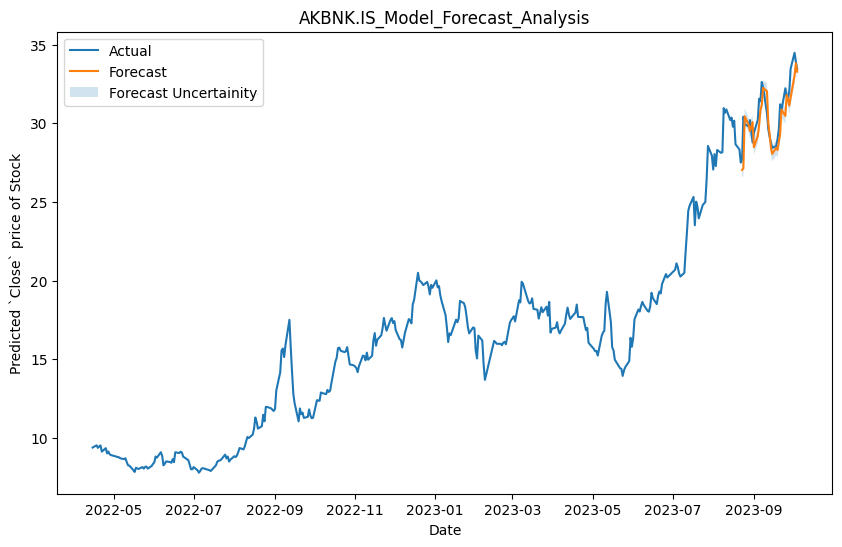

In [121]:
# Plotting predictions and uncertainity interval with respect to actuals
fig = plt.figure(figsize=(10, 6))

# Plot actuals
plt.plot(historical_data.Date.iloc[-365:], historical_data.Close.iloc[-365:])

# Plot forecasts for the latest 365 days as validation period
plt.plot(forecast.ds, forecast.yhat)

# Plot uncertainity - lower and upper bound for the forecasts
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, alpha=0.2)

plt.xlabel("Date")
plt.ylabel("Predicted `Close` price of Stock")
plt.legend(["Actual", "Forecast", "Forecast Uncertainity"])
plt.title(f"{ticker}_Model_Forecast_Analysis")
plt.show()

In [123]:
# General metrics
from sklearn.metrics import mean_absolute_error

# Mean absolute error metric
def mae(y, yhat):
    return mean_absolute_error(y, yhat)

In [124]:
validation.Date.min(), validation.Date.max()

(Timestamp('2023-08-23 00:00:00'), Timestamp('2023-10-04 00:00:00'))

In [125]:
forecast.ds.min(), forecast.ds.max()

(Timestamp('2023-08-23 00:00:00'), Timestamp('2023-10-04 00:00:00'))

In [126]:
"Mean absolute error (Closing price of the stock) = ", mae(validation.Close, forecast.yhat)

('Mean absolute error (Closing price of the stock) = ', 0.8276742241926268)

and as a comparison bwtween LSTM and another model like prophet we can see that the mean absolute error as a metric between them is less and as recap we can say in this case that FBPRPHET is efficient more than lstm 